# Marijuana Sales Prediction

## Objective
- Find the most relevent features for total sales income. 

## Import Required Libraries

In [408]:
# Import system tools
import os 
import sys
import warnings

# import numerical tools
import math
import numpy as np
import scipy as sp

# import dataframe tools
import pandas as pd

# import plotting packages
import seaborn as sns
import matplotlib.pyplot as plt

#===================Sci-kit Learn packages===================
# ML pipeline tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
# data preprocess tools (feature engineering)
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
# ML models
# linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# tree model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# support vector machine
from sklearn.svm import SVR 
# dimension reduction 
from sklearn.decomposition import PCA
# grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# progress bar 
from tqdm import tqdm
# import pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.optim
# live loss plot 
from livelossplot import PlotLosses


## Load Data

In [409]:
%reload_ext autoreload
%autoreload 2
# turn-off pandas warnings
warnings.filterwarnings('ignore')

# Load Dataset
avgRetail = pd.read_csv("../data/BrandAverageRetailPrice.csv")
brandDetail = pd.read_csv("../data/BrandDetails.csv")
totalSales = pd.read_csv("../data/BrandTotalSales.csv")
totalUnits = pd.read_csv("../data/BrandTotalUnits.csv")

## Construct Dataset
- General Info (choose initial dataset)
- Construct time-series data
- EDA/Add new feature

### Total Sales Data
- This dataset has the featured directly related to out objective, and also it contains only few features. Above reasons make it a good starting point to construct our train/test data. 

In [410]:
totalSales.info()
totalSales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Months           25279 non-null  object
 1   Brand            25279 non-null  object
 2   Total Sales ($)  25279 non-null  object
dtypes: object(3)
memory usage: 592.6+ KB


,Months,Brand,Total Sales ($)
0,09/2018,10x Infused,"1,711.334232"
1,09/2018,1964 Supply Co.,"25,475.21594500000"
2,09/2018,3 Bros Grow,"120,153.644757"
3,09/2018,3 Leaf,"6,063.5297850000000"
4,09/2018,350 Fire,"631,510.0481550000"


### Check time stamp
- Goal: check whether it's a regular time-series data
- Conclusion: It's a regular time-seris data
- Action: Time-series data interpolation is available while adding new features

In [411]:
# check whether it's a regular time-series data
tempt = totalSales[totalSales.Brand == "Garden Society"]
tempt["Months"].astype("datetime64[ns]").diff().value_counts()

31 days    21
30 days    12
28 days     2
29 days     1
Name: Months, dtype: int64

### Organize Total Sales Data
- Convert "Months" feature into datetime format
- Convert Sales to data-type float 

In [412]:
# convert the time stamp dataset
totalSales["Months"] = totalSales["Months"].astype(str).astype('datetime64[ns]')
# convert salses data to numerical data form
totalSales["Total Sales ($)"] = totalSales["Total Sales ($)"].str.replace(',','')
totalSales["Total Sales ($)"] = totalSales["Total Sales ($)"].astype(float)
totalSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brand            25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


### Lists to be analyzed brands
- Observation
    1. Total number of data has largest group locate in 37 data
    2. Ignore the brands that are lack of reported data
    3. Set the threshold to 37 data 

The largest group has 195 data
With current threshold, data information loss: 33.25%


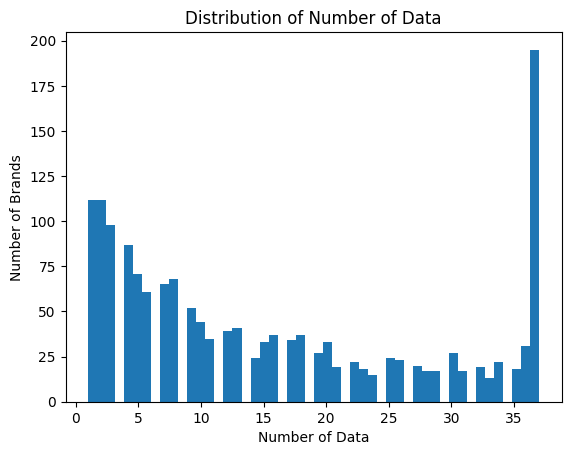

In [413]:
# Find the distribution of the #brand_data
numBrandData = pd.DataFrame()
numBrandData.loc[:, "Brand"] = totalSales.loc[:, "Brand"]
numBrandData.loc[:, "brand_count"] = [1]*len(totalSales["Brand"])
# count each brand's total number of reported data
numBrandData = numBrandData.groupby(["Brand"]).sum()
fig, axis = plt.subplots(1, 1)
counts, edges, bars = axis.hist(numBrandData["brand_count"], bins=50)
plt.title("Distribution of Number of Data")
plt.xlabel("Number of Data")
plt.ylabel("Number of Brands")
print(f"The largest group has {counts[-1]:.0f} data")

# filter out lack-of data brands
dataThreshold = 7
infoLoss = 1 - (len(numBrandData[numBrandData.brand_count >= dataThreshold])/len(numBrandData))
print(f"With current threshold, data information loss: {infoLoss:.2%}")


### Construct Initial Dataset
- Initialize dataset through copying total sales data
- Group dataset by Brand
- Filtered out the brands that #data is under threshold

#### Filtered Brand List
- Find the list of brands that number of data is above threshold

In [414]:
brandList = pd.DataFrame()
brandList.loc[:, "Brand"] = totalSales.loc[:, "Brand"]
brandList.loc[:, "Count"] = [1]*len(totalSales["Brand"])
brandList = brandList.groupby(by="Brand").sum()
brands = brandList[brandList.Count >= dataThreshold].index
print(len(brands))

1086


#### Initialize each brands data in dictionary

In [415]:
# initialize data
brandsData = dict()
for brand in brands:
    brandsData[brand] = totalSales[totalSales.Brand == brand]

#### EDA Sales Features
- Explore Correlation: 
    - Previous month sales
    - 3 months rolling sales
    - 6 months rolling sales 
- Result
    - previous month sales (strong correlation)
    - 3 months rolling sales (strong correlation)
    - 6 months rolling sales (weak correlation)
- Action
    - Adding "Previous Month Sales" & "3 months rolling sales" as new feature. 

In [416]:
# Calculate correlation between sales data
prevMonth_cor = []
roll3Month_cor = []
roll6Month_cor = []

for count, brand in enumerate(brands):   

    curSale = brandsData[brand].loc[:,"Total Sales ($)"]
    #==============add last month data===============================================
    prevSale = brandsData[brand].loc[:,"Total Sales ($)"].shift(-1)

    #===========Adding Rolling Sales Data===========
    # add rolling sales data (for three months)
    # calcualte the sum
    rollSum, rollMonths = 0, 3
    for month in range(1, rollMonths + 1): 
        rollSum += brandsData[brand].loc[:,"Total Sales ($)"].shift(-1 * month)
    roll3MonthSale = rollSum / rollMonths
    roll3MonthSale = roll3MonthSale[~np.isnan(roll3MonthSale)]

    # add rolling sales data (for six months)
    rollSum, rollMonths = 0, 6
    for month in range(1, rollMonths + 1): 
        rollSum += brandsData[brand].loc[:,"Total Sales ($)"].shift(-1 * month)
    roll6MonthSale = rollSum / rollMonths
    roll6MonthSale = roll6MonthSale[~np.isnan(roll6MonthSale)]

    cor2 = np.corrcoef(curSale[:len(roll3MonthSale)], roll3MonthSale)
    roll3Month_cor.append(cor2[1][0])
    
    cor3 = np.corrcoef(curSale[:len(roll6MonthSale)], roll6MonthSale)
    roll6Month_cor.append(cor3[1][0])

In [417]:
# find out not-correlation percentage
roll3_perc = np.sum(np.isnan(roll3Month_cor)) / len(roll3Month_cor)
roll6_perc = np.sum(np.isnan(roll6Month_cor)) / len(roll6Month_cor)
print(f"3 months rolling vs Previous has {roll3_perc:.2%} completely not correlated")
print(f"6 months rolling vs Previous has {roll6_perc:.2%} completely not correlated")

3 months rolling vs Previous has 0.00% completely not correlated
6 months rolling vs Previous has 5.99% completely not correlated


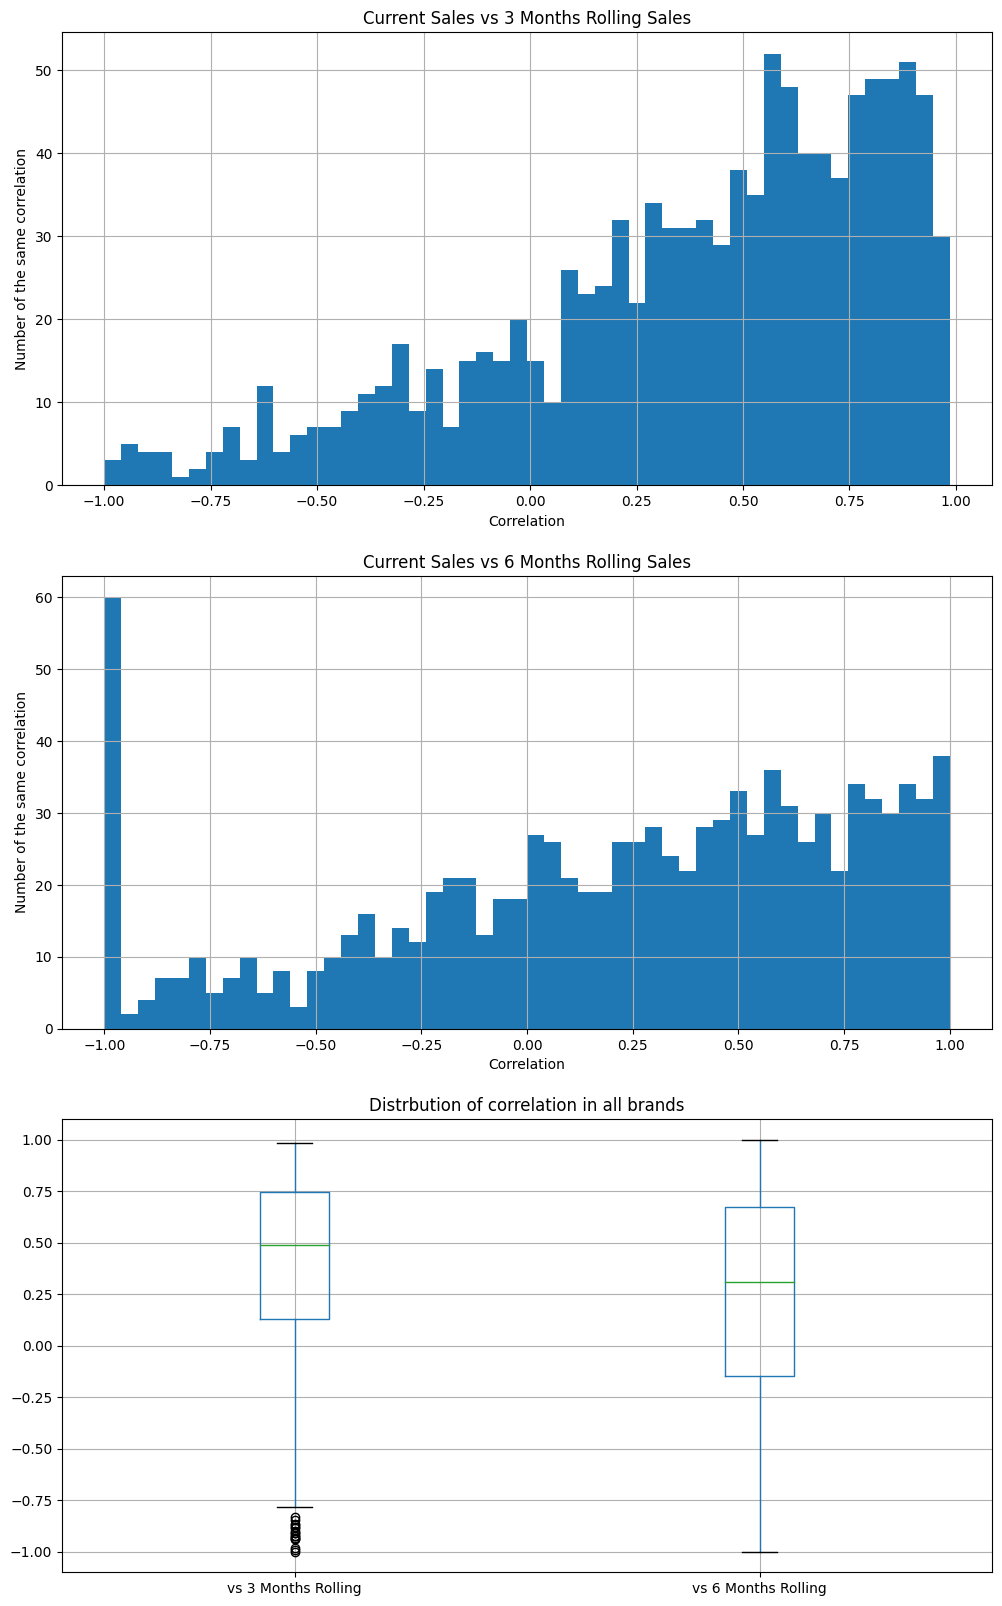

In [418]:
sales_cor = pd.DataFrame()
sales_cor.loc[:, "vs 3 Months Rolling"] = roll3Month_cor 
sales_cor.loc[:, "vs 6 Months Rolling"] = roll6Month_cor 

fig, axis = plt.subplots(3, 1, figsize=(12, 20))
sales_cor["vs 3 Months Rolling"].hist(bins=50, ax=axis[0])
axis[0].set_title("Current Sales vs 3 Months Rolling Sales")
axis[0].set_xlabel("Correlation")
axis[0].set_ylabel("Number of the same correlation")

sales_cor["vs 6 Months Rolling"].hist(bins=50, ax=axis[1])
axis[1].set_title("Current Sales vs 6 Months Rolling Sales")
axis[1].set_xlabel("Correlation")
axis[1].set_ylabel("Number of the same correlation")

sales_cor.boxplot(ax=axis[2])
axis[2].set_title("Distrbution of correlation in all brands")

plt.show()

#### Adding Sales Features

In [419]:
# construct all brands data
for brand in brands:   
    #==============add last month data===============================================
    brandsData[brand].loc[:, 'Previous Month Sales'] = brandsData[brand].loc[:,"Total Sales ($)"].shift(-1)

    #===========Adding Rolling Sales Data===========
    # add rolling sales data (for three months)
    # calcualte the sum
    rollSum, rollMonths = 0, 3
    for month in range(1, rollMonths + 1): 
        rollSum += brandsData[brand].loc[:,"Total Sales ($)"].shift(-1 * month)
    brandsData[brand].loc[:, 'Rolling Sales (3 months)'] = rollSum / rollMonths

    rollSum, rollMonths = 0, 6
    for month in range(1, rollMonths + 1): 
        rollSum += brandsData[brand].loc[:,"Total Sales ($)"].shift(-1 * month)
    brandsData[brand].loc[:, 'Rolling Sales (6 months)'] = rollSum / rollMonths


### EDA Total Units Data
- Explore whether total Units have large affect on sales data. 
- Assumption:   
    - Total units has high correlation with sales data. 
- Conclusion: 
- Action: 
    - Add total units as new feature

In [420]:
totalUnits.info()
totalUnits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brands            27686 non-null  object 
 1   Months            27686 non-null  object 
 2   Total Units       25712 non-null  object 
 3   vs. Prior Period  24935 non-null  float64
dtypes: float64(1), object(3)
memory usage: 865.3+ KB


,Brands,Months,Total Units,vs. Prior Period
0,#BlackSeries,08/2020,"1,616.3390040000000",NaN
1,#BlackSeries,09/2020,NaN,-1.000000
2,#BlackSeries,01/2021,715.5328380000000,NaN
3,#BlackSeries,02/2021,766.669135,0.071466
4,#BlackSeries,03/2021,NaN,-1.000000


#### Merge Total Units data with total sales base on same time stamp

In [421]:
# change time data
totalUnits["Months"] = totalUnits["Months"].astype("datetime64[ns]")
for ctr, brand in enumerate(brands): 
    # preprocess current brands total units data 
    brandUnits = totalUnits[totalUnits.Brands == brand].copy()
    brandUnits.loc[:,"Total Units"] = brandUnits.loc[:,"Total Units"].str.replace(',', '')
    brandUnits.loc[:,"Total Units"] = brandUnits.loc[:,"Total Units"].astype(float)
    # merge the data (only if it haven't been merged before)
    if "Total Units" not in brandsData[brand].columns:
        brandsData[brand] = brandsData[brand].merge(
            brandUnits.drop(columns=["vs. Prior Period", "Brands"]), 
            right_on="Months", left_on="Months")
    brandsData[brand].head()

### EDA Brand Detail
- Eplore Features: 
    - L1 Category
- Conclusion: 
    - Inhaleables and Ingestibles are the largest sold product not only in volume but also in income sales. 
- Action: 
    - Adding "Inhaleables" and "Ingestibles" as new features. 

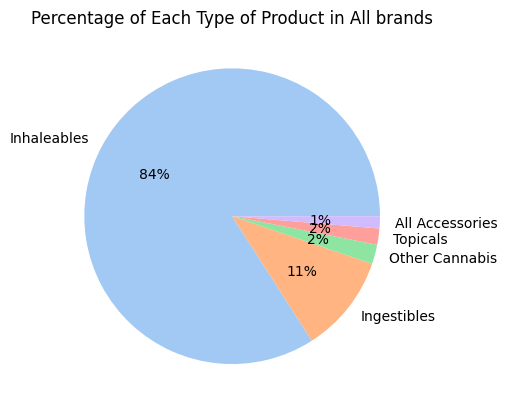

In [422]:
catL1 = brandDetail["Category L1"].copy()
catL1Type = list(catL1.value_counts().index)
catL1Val = list(catL1.value_counts().values)
colors = sns.color_palette('pastel')[0:5]
plt.pie(catL1Val, labels=catL1Type, colors=colors, autopct='%.0f%%')
plt.title("Percentage of Each Type of Product in All brands")
plt.show()

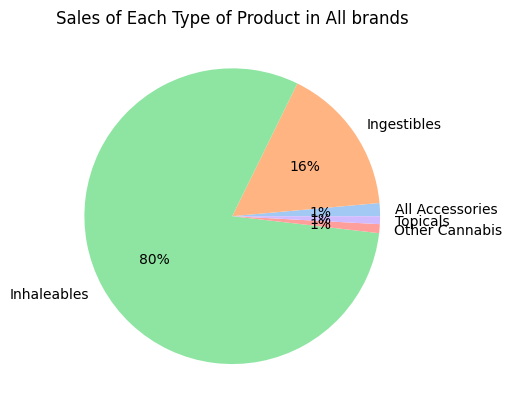

In [423]:
catL1_sales = brandDetail[["Category L1", "Total Sales ($)"]].copy()
catL1_sales["Total Sales ($)"] = catL1_sales["Total Sales ($)"].str.replace(",",'').astype(float)
catL1_sales = catL1_sales.groupby(by="Category L1").sum()


colors = sns.color_palette('pastel')[0:5]
plt.pie(catL1_sales["Total Sales ($)"], labels=catL1_sales.index, colors=colors, autopct='%.0f%%')
plt.title("Sales of Each Type of Product in All brands")
plt.show()

In [424]:
# Adding New feature in the data
for ctr, brand in enumerate(brands): 
    curBrandDetail = brandDetail[brandDetail.Brand == brand]
    if "Sell Inhaleables" not in brandsData[brand].columns:
        brandsData[brand].loc[:, "Sell Inhaleables"] = int("Inhaleables" in curBrandDetail["Category L1"].values)
    if "Sell Ingestibles" not in brandsData[brand].columns: 
        brandsData[brand].loc[:, "Sell Ingestibles"] = int("Ingestibles" in curBrandDetail["Category L1"].values)

## Data Preprocess
- Create pipeline (preprocessing)
- Hyper-parameters 
- Split dataset

### Current Dataset

In [425]:
brandsData["Ganja Gold"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Months                    37 non-null     datetime64[ns]
 1   Brand                     37 non-null     object        
 2   Total Sales ($)           37 non-null     float64       
 3   Previous Month Sales      36 non-null     float64       
 4   Rolling Sales (3 months)  34 non-null     float64       
 5   Rolling Sales (6 months)  31 non-null     float64       
 6   Total Units               37 non-null     float64       
 7   Sell Inhaleables          37 non-null     int64         
 8   Sell Ingestibles          37 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 2.9+ KB


### Create Pipeline

In [426]:
#=================Individal Pipeline===================
#******************Sales data******************
sales_features = [
    "Total Sales ($)", 
    "Previous Month Sales", 
    "Rolling Sales (3 months)", 
    "Rolling Sales (6 months)", 
]
sales_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"), 
    StandardScaler() # normalize data
)

#******************Units data******************
units_features = [
    "Total Units",
]
units_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler() # normalize data
)

#*****************Product data******************
productType_features = [
    "Sell Inhaleables", 
    "Sell Ingestibles"
]
productType_pipeline = make_pipeline(
    KNNImputer(n_neighbors=2), 
)

#***************Default Pipelien*****************
# for numerical and category specifically
num_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"), 
    StandardScaler()
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), 
    OrdinalEncoder(),
    StandardScaler()
)

#======================Final Preprocess Pipeline======================
preprocess = ColumnTransformer([
    ("Sales", sales_pipeline, sales_features),  # sales features pipeline
    ("Units", units_pipeline, units_features),  # total units features pipeline
    ("Product_type", productType_pipeline, productType_features), # different type of products pipeline
    ("Default_cat", cat_pipeline, make_column_selector(dtype_include=object))    
    ],
    remainder= num_pipeline
)

### Preprocess Data

In [427]:
brands_X = dict()
brands_y = dict()
for ctr, brand in enumerate(brands): 
    # drop the "Months" data
    if "Months" in brandsData[brand].columns:
        brandsData[brand] = brandsData[brand].drop("Months", axis=1)
    # drop the "Brands" data
    if "Brand" in brandsData[brand].columns:
        brandsData[brand] = brandsData[brand].drop("Brand", axis=1)

    # get the output (Total Sales) data index 
    y_index = brandsData[brand].columns.to_list().index("Total Sales ($)")

    # preprocess data
    brandsData_prep = preprocess.fit_transform(brandsData[brand])

    # extract input and output data of each brand
    brands_X[brand] = np.delete(brandsData_prep, y_index, 1)
    brands_y[brand] = brandsData_prep[:, y_index]

### Combine All Brands Data into A Single Dataset

In [428]:
X, y = None, None
for ctr, brand in enumerate(brands): 
    # create input data
    if X is None: 
        X = brands_X[brand]
    else:
        X = np.concatenate((X, brands_X[brand]), axis=0)
    # create output data
    if y is None: 
        y = brands_y[brand]
    else: 
        y = np.concatenate((y, brands_y[brand]), axis=0)
print("=============================================================")
print(f"We have {X.shape[0]} input data with {X.shape[1]} features.")
print(f"And {y.shape[0]} output data.")

We have 23580 input data with 6 features.
And 23580 output data.


## Deploy ML
- Linear Model
- Tree's Model
- Bagging and Boosting
- Neural Network

### Hyper-parameters

In [429]:
# initialize all hypterparameters in dictionary forms
params = {
    "test_ratio" : 0.1, 
    "val_ratio": 0.15, 
    "learning_rate" : 1e-3, 
    "batch_size": 200, 
    "epoches" : 100, 
    "stop_point" : 200, 
    "input_dim" : None, 
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu', 
}
# print-out all hyperparameters
print(params)

{'test_ratio': 0.1, 'val_ratio': 0.15, 'learning_rate': 0.001, 'batch_size': 200, 'epoches': 100, 'stop_point': 200, 'input_dim': None, 'device': 'cpu'}


### Split Data for Later Train/Val and Test

In [430]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=params["test_ratio"])

In [431]:
print(f"Training Size {X_train.shape}")
print(f"Test Size {X_test.shape}")

Training Size (21222, 6)
Test Size (2358, 6)


### Linear Model

In [432]:
linear_regression = LinearRegression()
# train model
linear_regression.fit(X_train, y_train)
# test model
y_predict = linear_regression.predict(X_test)
err = mean_squared_error(y_test, y_predict)

acc = 1 - err
print("============Linear Regression=============")
print(f"Accuracy: {acc:.2%}, Loss: {err:.2%}")
print("==========================================")


============Linear Regression=============
Accuracy: 89.41%, Loss: 10.59%


### Neural Network for Regression

#### Create Tensor Dataset/Dataloader

In [433]:
# Create tensor dataset class 
class SalesDataset(Dataset): 
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [434]:
# create validation dataset
train_input, train_output = X_train, y_train
X_train_new, X_val, y_train_new, y_val = train_test_split(train_input, train_output, test_size=params["val_ratio"])
print(f"With training:{X_train_new.shape[0]}, validation:{X_val.shape[0]} of data, with {X_train_new.shape[1]} features.")

# Assign training hypter-parameters
params["input_dim"] = X_train_new.shape[1]
params["batch_size"] = 32 

# Create tensor dataset
train_dataset   = SalesDataset(X_train_new, y_train_new)
val_dataset     = SalesDataset(X_val, y_val)
test_dataset    = SalesDataset(X_test, y_test) 
# Create tensor dataloader to load on torch model
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True)

With training:18038, validation:3184 of data, with 6 features.


#### Create Training NN model

In [439]:
class NN_Model_Baseline(nn.Module): 
    def __init__(self, input_dim, output_dim=1): 
        super(NN_Model_Baseline, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_dim)
        )
        
    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x 

#### NN Training Process Utils

In [449]:
def train_model(model, train_loader, val_loader, params): 
    #================Initialize parameters================
    nEpoches = params["epoches"]
    step, earlyStopCtr = 0, 0
    device = params["device"]
    acc, loss = 0, 0
    trainLoss, valLoss = 0, 0
    bestAcc, bestModel = 0, None
    optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
    criteria = nn.MSELoss(reduce="mean") # loss function 
    #=======Initialize Livelossplot and tensorboard==============
    liveloss = PlotLosses()
    boardWriter = SummaryWriter()
    for epoch in range(nEpoches+1): 
        #============Training Phase============
        model.train() # switch to training mode
        train_record = []
        for X_train, y_train in train_loader: 
            # load data to device
            X_train, y_train = X_train.to(params["device"]), y_train.to(params["device"])
            # zerolize gradiend 
            optimizer.zero_grad()
            # Forward Propagation
            pred = model(X_train)
            # calculate loss 
            loss = criteria(pred, y_train)
            # calculate each backpropagation values
            loss.backward()
            # update parameters with previous values
            optimizer.step()
            # accumulate step
            step += 1
            # record current loss 
            train_record.append(loss.detach().item())
        # calculate average loss
        trainLoss = sum(train_record) / len(train_record)
        #============Validation Phase============
        model.eval() # switch to validation mode
        val_record = []
        for X_val, y_val in val_loader: 
            X_val,  y_val = X_val.to(params["device"]), y_val.to(params["device"])
            with torch.no_grad(): 
                pred = model(X_val)
                loss = criteria(pred, y_val)
            val_record.append(loss.item())
        # calculate average loss 
        valLoss = sum(val_record) / len(val_record)
        
        #========update liveloss and tensorboard plot==========
        boardWriter.add_scalar("Loss/Train", trainLoss, step)
        boardWriter.add_scalar("Loss/Val", valLoss, step)
        liveloss.update({
            'loss': trainLoss, 
            'val_loss': valLoss
        })
        liveloss.send()
        #=====checking early stopping point====
        if acc >= bestAcc: 
            earlyStopCtr = 0
            bestAcc, bestModel = acc, model
        else: 
            earlyStopCtr += 1
            if earlyStopCtr >= params["stop_point"]: 
                print("Stop training for early stopping")
                return


#### Training

In [437]:
print(params)

{'test_ratio': 0.1, 'val_ratio': 0.15, 'learning_rate': 0.001, 'batch_size': 32, 'epoches': 100, 'stop_point': 200, 'input_dim': 6, 'device': 'cpu'}


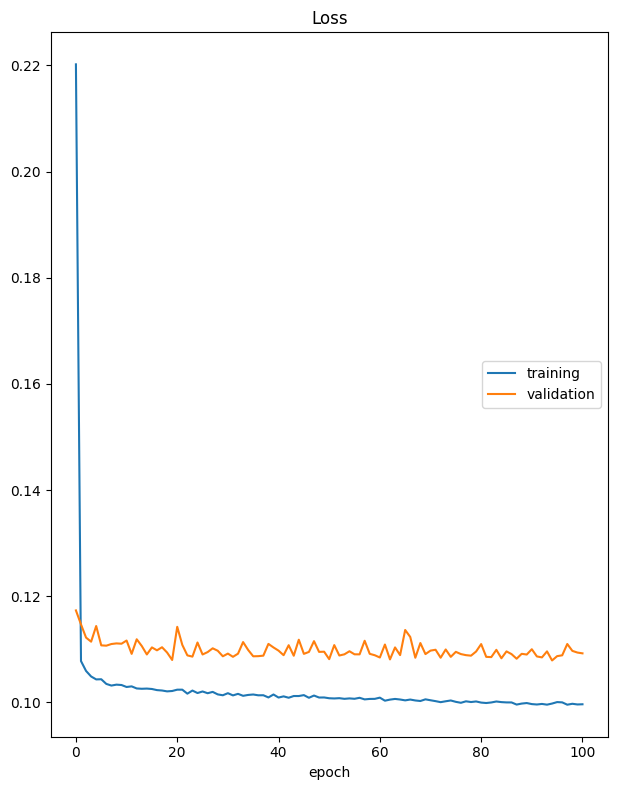

Loss
	training         	 (min:    0.100, max:    0.220, cur:    0.100)
	validation       	 (min:    0.108, max:    0.117, cur:    0.109)


In [450]:
input_dim = int(params["input_dim"])
model = NN_Model_Baseline(input_dim=input_dim, output_dim=1).to(params["device"])
train_model(model=model ,train_loader=train_loader, val_loader=val_loader, params=params)

## Conclusion 
- Training/Testing result 
    1. Score
- Visualization Result
- Discussion
    1. Recommended action